# Shared notebook edited by Daniel

### CV Theory

#### What is YOLO?


YOLO stands for You Only Look Once. It is a real-time object recognition algorithm. It can classify and localize multiple objects in a single frame. YOLO is a very fast and accurate algorithm for its simpler network architecture.

#### How does YOLO work?

YOLO works using mainly these techniques.

1. Residual Blocks – Basically, it divides an image into NxN grids.

2. Bounding Box regression – Each grid cell is sent to the model. Then YOLO determines the probability of the cell contains a certain class and the class with the maximum probability is chosen.

3. Intersection Over Union (IOU) – IOU is a metric that evaluates intersection between the predicted bounding box and the ground truth bounding box. A Non-max suppression technique is applied to eliminate the bounding boxes that are very close by performing the IoU with the one having the highest class probability among them.

#### YOLO for Object Detection

There are three main variations of the approach; they are YOLOv1, YOLOv2, and YOLOv3. The first version proposed the general architecture, whereas the second version refined the design and made use of predefined anchor boxes to improve bounding box proposal, and version three further refined the model architecture and training process. Although the accuracy of the models is close but not as good as Region-Based Convolutional Neural Networks (R-CNNs), they are popular for object detection because of their detection speed, often demonstrated in real-time on video or with camera feed input.m

#### Object Detection with YOLOv3

The keras-yolo3 project provides a lot of capability for using YOLOv3 models, including object detection, transfer learning, and training new models from scratch. In this kernel, we will use a pre-trained model to perform object detection on an unseen photograph.

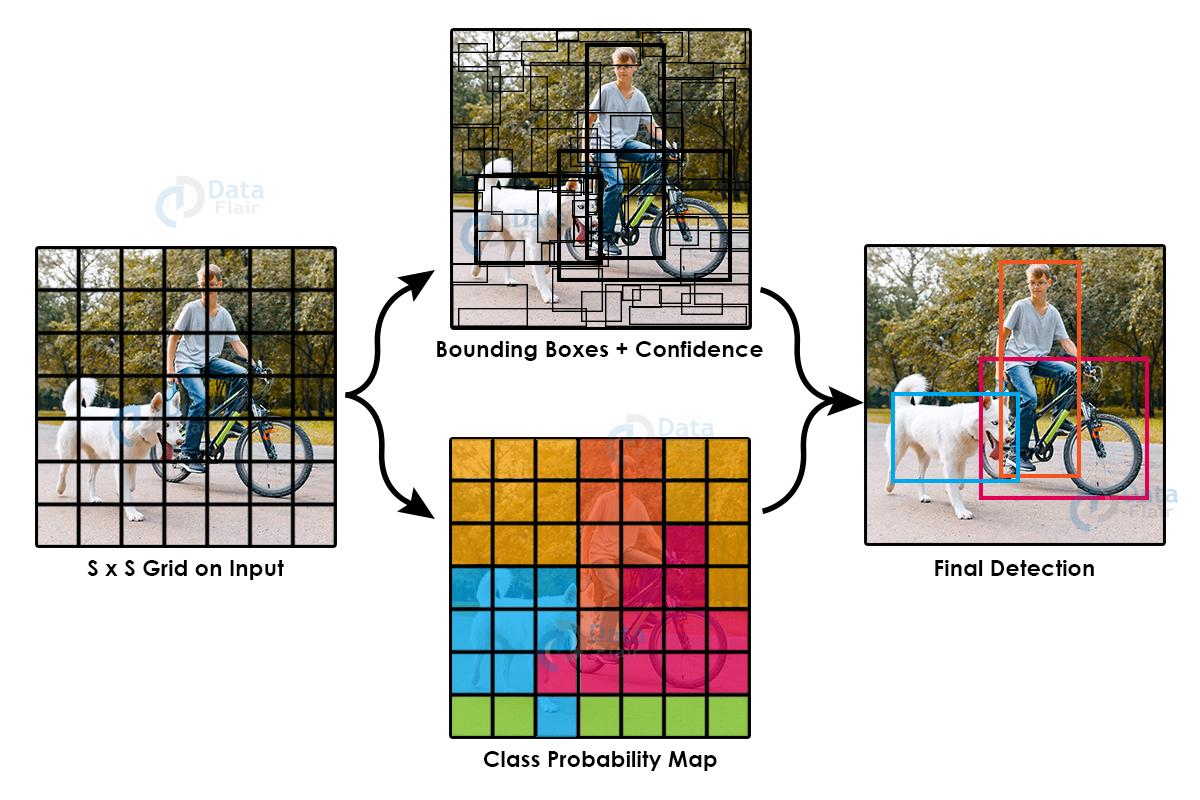

### 0. Import libraries

In [3]:
# Import Libraries

# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

### 1. Data Load

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

path_annotrain = "../datasets/datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)

bbox_train_full = train_annotation.loc[
    :, ["im_name", "x_min", "y_min", "x_max", "y_max"]
]




def load_plot(im_name, x1, y1, x2, y2):

    im = np.asanyarray(Image.open(f"../datasets/datasets_train/train/{im_name}"))

    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()


#### 1.1 Check annotations

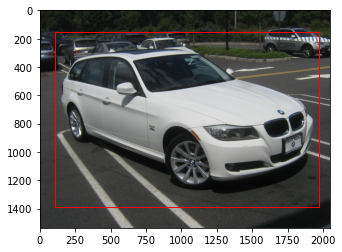

In [ ]:
im_test = bbox_train_full.iloc[111, 0]
x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]

load_plot(im_test, x1, y1, x2, y2)

#### 1.2 Visualizing Data

In [ ]:
train_annotation.head()

,im_name,x_min,y_min,x_max,y_max,class,models
0,107347968.jpg,40.0,244.0,1144.0,637.0,car,Audi S5 Convertible 2012
1,91160576.jpg,4.0,9.0,98.0,76.0,car,Audi 100 Wagon 1994
2,273809408.jpg,16.0,4.0,288.0,191.0,car,Cadillac SRX SUV 2012
3,579534848.jpg,14.0,23.0,255.0,178.0,car,Ford Freestar Minivan 2007
4,950599680.jpg,4.0,70.0,321.0,215.0,car,Rolls-Royce Phantom Sedan 2012


In [ ]:
train_annotation.shape

(2641, 7)

### 2.Transform the dataset

In [14]:
data_dir = '../datasets/datasets_train/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['.ipynb_checkpoints']


In [5]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("../datasets/datasets_train/train", transform=train_transforms)
# test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
# valid_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
# validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

### 3. Create model

In [7]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

### 4. Train model

In [15]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [20]:
epochs = 10
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
#         # Carrying out validation step
#         if steps % print_every == 0:
#             # setting model to evaluation mode during validation
#             model.eval()
            
#             # Gradients are turned off as no longer in training
#             with torch.no_grad():
#                 valid_loss, accuvalidracy = validation(model, validloader, criterion)
            
#             print(f"No. epochs: {e+1}, \
#             Training Loss: {round(running_loss/print_every,3)} \
#             Valid Loss: {round(valid_loss/len(validloader),3)} \
#             Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
        # Turning training back on
        model.train()
        # lrscheduler.step(accuracy * 100)

In [21]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

ZeroDivisionError: division by zero